In [1]:
!nvidia-smi
%matplotlib inline

Sun Jul  6 10:09:51 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.57.01              Driver Version: 565.57.01      CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          On  |   00000000:CA:00.0 Off |                    0 |
| N/A   30C    P0             52W /  400W |       1MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [8]:
%matplotlib inline

In [2]:
import dspy
import pandas as pd
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm import tqdm
from typing import List, Literal
from dspy.evaluate import Evaluate
from dspy import LabeledFewShot
from dspy.teleprompt import BootstrapFewShotWithRandomSearch
import numpy as np

In [3]:
def obtain_results_without(input_csv, filter_set):
    result_df = pd.read_csv(input_csv)
    result_df = result_df[result_df['direct_source']!=filter_set]
    print(classification_report(result_df["gold_judgment"], result_df['model_pred']))

    judgment_gold = result_df['gold_judgment'].tolist()
    judgment_model = result_df["model_pred"].tolist()
    binary_labels = ['underspecified', 'fully specified']

    cm = confusion_matrix(judgment_gold, judgment_model, labels=binary_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=binary_labels)

    disp.plot(cmap='Blues')  # 可以调整 colormap

In [4]:
# For Snellius
input_csv = "../data/few_shots.csv"
df_few_shots = pd.read_csv(input_csv)
real_csv = "../data/Test_1155.csv"
df_test_1155 = pd.read_csv(real_csv)
learning_csv = "../data/in-context_learning_set.csv"
df_in_context_learning = pd.read_csv(learning_csv)
learning_A_csv = "../data/learning_version_A.csv"
df_in_context_learning_A = pd.read_csv(learning_A_csv)
learning_B_csv = "../data/learning_version_B.csv"
df_in_context_learning_B = pd.read_csv(learning_B_csv)

In [ ]:
"""
module load CUDA/12.4.0
source ~/sglang-venv-2/bin/activate
huggingface-cli login


# 创建所有必要的目录
mkdir -p /scratch-local/yhuang/sglang_cache
mkdir -p /scratch-local/yhuang/huggingface_cache
mkdir -p /scratch-local/yhuang/torch_cache
mkdir -p /scratch-local/yhuang/cuda_cache
mkdir -p /scratch-local/yhuang/xdg_cache
mkdir -p /scratch-local/yhuang/tmp
mkdir -p /scratch-local/yhuang/logs

# 设置所有相关环境变量
export SGLANG_CACHE_DIR=/scratch-local/yhuang/sglang_cache
export TRANSFORMERS_CACHE=/scratch-local/yhuang/huggingface_cache
export HF_HOME=/scratch-local/yhuang/huggingface_cache
export HF_DATASETS_CACHE=/scratch-local/yhuang/huggingface_cache/datasets
export TORCH_HOME=/scratch-local/yhuang/torch_cache
export CUDA_CACHE_PATH=/scratch-local/yhuang/cuda_cache
export XDG_CACHE_HOME=/scratch-local/yhuang/xdg_cache
export TMPDIR=/scratch-local/yhuang/tmp
export TEMP=/scratch-local/yhuang/tmp
export TMP=/scratch-local/yhuang/tmp
export SGLANG_LOG_DIR=/scratch-local/yhuang/logs

# launching
python -m sglang.launch_server --port 7501 --model-path Qwen/Qwen3-4B --trust-remote-code
CUDA_VISIBLE_DEVICES=0,1 python -m sglang.launch_server --port 7501 --model-path Qwen/Qwen3-32B --trust-remote-code --tp 2
"""

In [6]:
def dspy_cot_theory(lm, input_list, class_to_use):
    category_list = []
    judgment_list = []
    reasoning_list = []

    dspy.configure(lm=lm)
    classification = class_to_use

    for item in tqdm(input_list, desc="Processing: "):
        try:
          result = classification(request = item)
          category_list.append(result.category)
          judgment_list.append(result.judgment)
          reasoning_list.append(result.reasoning)
        except Exception as e:
          print(f'Error processing item: {item}')
          print(f'Error message: {e}')
          category_list.append("error")
          judgment_list.append("error")
          reasoning_list.append("error")

    return category_list, judgment_list, reasoning_list


def collect_thinking(loaded_model):
  history_data = loaded_model.history
  think_list = []
  print(f'The current length of history is {len(history_data)}.')

  for record in history_data:
      thinking = record['outputs'][0].split("[[ ## reasoning ## ]]")[0]
      think_list.append(thinking)

  return think_list

# Data loading and preprocessing
def load_data_theory(csv_path):
    """Load CSV data and convert to DSPy examples"""
    df = pd.read_csv(csv_path)

    examples = []
    for _, row in df.iterrows():
        if pd.notna(row['request']) and pd.notna(row['gold_judgment']):
            example = dspy.Example(
                request=row['request'],
                reasoning=row['reasoning'] if pd.notna(row['reasoning']) else '',
                category=row['category'] if pd.notna(row['category']) else '',
                judgment=row['gold_judgment']
            ).with_inputs('request')  # Only request is input
            examples.append(example)

    return examples

def run_experiment(test_df, model_in_use, program_in_use, think_file_name, input_col='request', theory=False):
  requests_to_test = test_df[input_col].tolist()

  if theory:
    category_list, judgment_list, reasoning_list = dspy_cot_theory(model_in_use, requests_to_test, program_in_use)
    df = test_df.copy()
    df['category'] = category_list
    df['model_pred'] = judgment_list
    df['reasoning'] = reasoning_list
    think_list = collect_thinking(model_in_use)
    print(f"The number of thinking pieces is {len(think_list)}.")
    think_df = pd.DataFrame(think_list)
    think_df.to_csv(f'{think_file_name}.csv')

  else:
    judgment_list, reasoning_list = dspy_cot_no_theory(model_in_use, requests_to_test, program_in_use)
    df = test_df.copy()
    df['model_pred'] = judgment_list
    df['reasoning'] = reasoning_list
    think_list = collect_thinking(model_in_use)
    print(f"The number of thinking pieces is {len(think_list)}.")
    think_df = pd.DataFrame(think_list)
    think_df.to_csv(f'{think_file_name}.csv')

  return df

def retrieve_results(result_df, output_name):
  judgment_list = result_df['model_pred'].tolist()

  if 'error' in judgment_list:
    print("There are errors in model predictions. The CSV file is saved but requires manual inspection.")
    result_df.to_csv(f'{output_name}_error.csv')
  else:
    print("No error is detected, proceed to evaluations.")
    print(classification_report(result_df['gold_judgment'], result_df['model_pred']))
    result_df.to_csv(f'{output_name}.csv')

  judgment_gold = result_df['gold_judgment'].tolist()
  judgment_model= result_df['model_pred'].tolist()

  binary_labels = ['underspecified', 'fully specified']

  cm = confusion_matrix(judgment_gold, judgment_model, labels=binary_labels)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=binary_labels)

  disp.plot(cmap='Blues')  # 可以调整 colormap

def find_model_pred_differences(df1, df2, key_column="request"):

    # 合并两个 DataFrame
    merged = df1.merge(df2, on=key_column, suffixes=("_df1", "_df2"))

    # 过滤出 model_pred 不相等的行
    diff = merged[merged["model_pred_df1"] != merged["model_pred_df2"]]

    return diff[[key_column, 'gold_judgment_df1', "model_pred_df1", "model_pred_df2"]]

In [6]:
model = dspy.LM("openai/Qwen/Qwen3-4B",
         api_base="http://localhost:7501/v1",
         api_key="whatever", model_type='chat',
         cache=False,
         temperature=0.0,
         max_tokens=5000)

In [12]:
class Classification(dspy.Signature):
  request: str = dspy.InputField(desc="An input user question/request.")
  category: Literal['Undetermined perspective or granularity', 'Missing necessary components', 'Undetermined lexicons or references', 'Undetermined standard or preference', 'fully specified']=dspy.OutputField(desc="Select one or more labels (comma-separated): Undetermined perspective or granularity, Missing necessary components, Undetermined lexicons or references, Undetermined standard or preference. If fully clear, output 'fully specified'")
  judgment: Literal['underspecified', 'fully specified'] = dspy.OutputField(desc="Final judgment: 'underspecified' if any undetermined factors exist, 'fully specified' if completely clear.")

In [13]:
# Load your in-context learning set, DO NOT compile from scratch repeatedly
examples = load_data_theory(learning_csv)
print(f"Loaded {len(examples)} samples from in-context learning set")

optimizer = dspy.LabeledFewShot(k=150)

# Compiling
program = dspy.ChainOfThought(Classification)
compiled_program = optimizer.compile(program, trainset=examples)

# Saving the program
compiled_program.save("./dspy_program/", save_program=True)

# One-shot Testing
dspy.configure(lm=model)
result = compiled_program(request="Who is the president?")
print(result)

Loaded 150 samples from in-context learning set
Prediction(
    reasoning='The request is underspecified because the term “president” can refer to multiple parallel political entities (e.g., U.S. president, French president, Chinese president), and the question lacks a necessary component to specify which country or jurisdiction is being referred to. Without this context, the referent remains ambiguous.',
    category='Undetermined lexicons or references',
    judgment='underspecified'
)


In [14]:
dspy.inspect_history()





[2025-07-05T12:14:58.231167]

System message:

Your input fields are:
1. `request` (str): An input user question/request.

Your output fields are:
1. `reasoning` (str)
2. `category` (Literal['Undetermined perspective or granularity', 'Missing necessary components', 'Undetermined lexicons or references', 'Undetermined standard or preference', 'fully specified']): Select one or more labels (comma-separated): Undetermined perspective or granularity, Missing necessary components, Undetermined lexicons or references, Undetermined standard or preference. If fully clear, output 'fully specified'
3. `judgment` (Literal['underspecified', 'fully specified']): Final judgment: 'underspecified' if any undetermined factors exist, 'fully specified' if completely clear.

All interactions will be structured in the following way, with the appropriate values filled in.

[[ ## request ## ]]
{request}

[[ ## reasoning ## ]]
{reasoning}

[[ ## category ## ]]
{category}        # note: the value you produ

# Pilot verification

In [15]:
pilot_result = run_experiment(df_few_shots, model, compiled_program, 'pilot_1_think_contents', theory=True)

Processing: 100%|██████████| 12/12 [02:12<00:00, 11.01s/it]

The current length of history is 16.
The number of thinking pieces is 16.


No error is detected, proceed to evaluations.
                 precision    recall  f1-score   support

fully specified       0.80      0.67      0.73         6
 underspecified       0.71      0.83      0.77         6

       accuracy                           0.75        12
      macro avg       0.76      0.75      0.75        12
   weighted avg       0.76      0.75      0.75        12



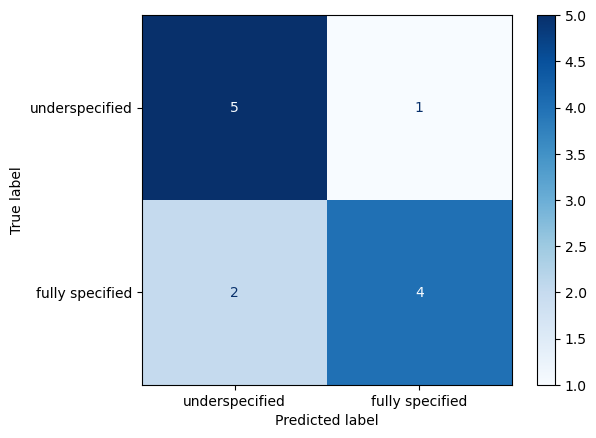

In [16]:
retrieve_results(pilot_result, 'pilot_1')

In [7]:
loaded_dspy_program = dspy.load("./dspy_program/")

In [8]:
pilot_result = run_experiment(df_few_shots, model, loaded_dspy_program, 'pilot_2_think_contents', theory=True)

Processing: 100%|██████████| 12/12 [01:11<00:00,  5.97s/it]

The current length of history is 14.
The number of thinking pieces is 14.


No error is detected, proceed to evaluations.
                 precision    recall  f1-score   support

fully specified       0.80      0.67      0.73         6
 underspecified       0.71      0.83      0.77         6

       accuracy                           0.75        12
      macro avg       0.76      0.75      0.75        12
   weighted avg       0.76      0.75      0.75        12



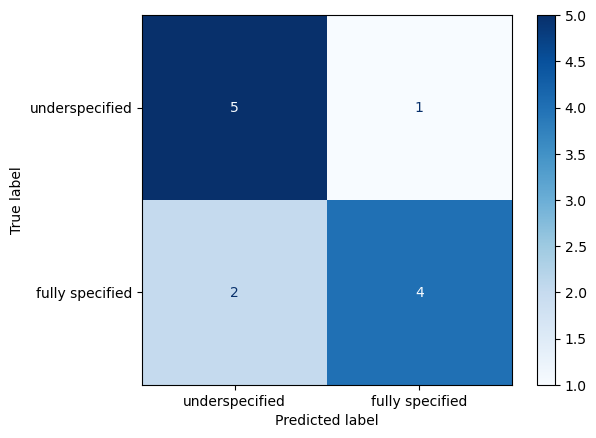

In [9]:
retrieve_results(pilot_result, 'pilot_2')

In [10]:
pilot_1 = pd.read_csv('pilot_1.csv')
pilot_2 = pd.read_csv('pilot_2.csv')
find_model_pred_differences(pilot_1, pilot_2)

,request,gold_judgment_df1,model_pred_df1,model_pred_df2


# Test set verification

In [6]:
model = dspy.LM("openai/Qwen/Qwen3-4B",
         api_base="http://localhost:7501/v1",
         api_key="whatever", model_type='chat',
         cache=False,
         temperature=0.0,
         max_tokens=5000)

In [8]:
loaded_dspy_program = dspy.load("./dspy_program/")

In [9]:
experiment_result = run_experiment(df_test_1155, model, loaded_dspy_program, 'test_1_think_contents', theory=True)

Processing: 100%|██████████| 1155/1155 [2:07:17<00:00,  6.61s/it] 

The current length of history is 1346.
The number of thinking pieces is 1346.


No error is detected, proceed to evaluations.
                 precision    recall  f1-score   support

fully specified       0.68      0.74      0.71       598
 underspecified       0.69      0.63      0.66       557

       accuracy                           0.69      1155
      macro avg       0.69      0.68      0.68      1155
   weighted avg       0.69      0.69      0.69      1155



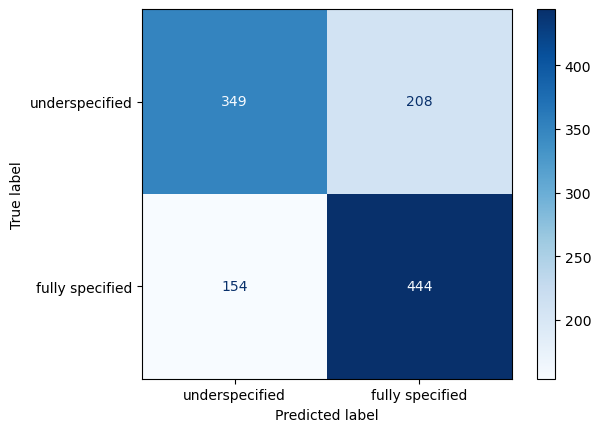

In [10]:
retrieve_results(experiment_result, 'test_1')

                 precision    recall  f1-score   support

fully specified       0.74      0.72      0.73       431
 underspecified       0.72      0.75      0.74       424

       accuracy                           0.73       855
      macro avg       0.73      0.73      0.73       855
   weighted avg       0.73      0.73      0.73       855



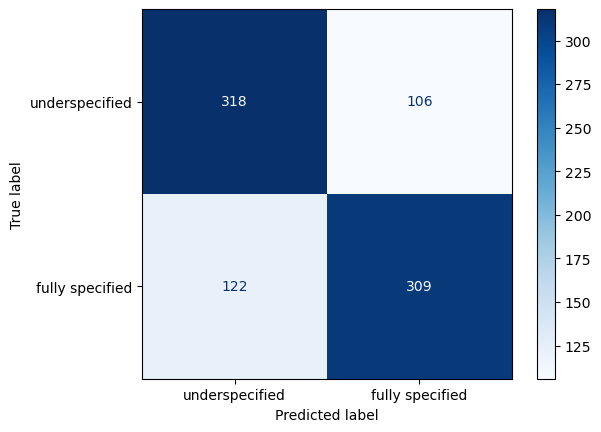

In [11]:
obtain_results_without('test_1.csv', 'AmbigQA')

In [13]:
history_data = model.history
import json

def convert_obj(obj):
    """将任意 Python/DSPy 对象转换为 JSON 可序列化结构，并尽量保留信息。"""
    if isinstance(obj, dict):
        return {k: convert_obj(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_obj(v) for v in obj]
    elif isinstance(obj, (str, int, float, bool)) or obj is None:
        return obj
    elif hasattr(obj, "text"):  # DSPy 的 response 类
        return {
            "_type": type(obj).__name__,
            "text": obj.text,
            "details": convert_obj(vars(obj))
        }
    elif hasattr(obj, "__dict__"):  # 一般自定义类
        return {
            "_type": type(obj).__name__,
            "attributes": convert_obj(vars(obj))
        }
    elif hasattr(obj, "__name__"):  # metaclass
        return {
            "_type": "metaclass",
            "name": obj.__name__
        }
    else:
        return {
            "_type": str(type(obj)),
            "repr": str(obj)
        }

# 处理 history
structured_history = [convert_obj(entry) for entry in model.history]

# 保存
with open("dspy_history_test_1.json", "w", encoding="utf-8") as f:
    json.dump(structured_history, f, ensure_ascii=False, indent=2)

In [7]:
loaded_dspy_program = dspy.load("./dspy_program/")

In [8]:
experiment_result = run_experiment(df_test_1155, model, loaded_dspy_program, 'test_2_think_contents', theory=True)

Processing: 100%|██████████| 1155/1155 [2:07:21<00:00,  6.62s/it] 

The current length of history is 1346.
The number of thinking pieces is 1346.


No error is detected, proceed to evaluations.
                 precision    recall  f1-score   support

fully specified       0.68      0.74      0.71       598
 underspecified       0.69      0.63      0.66       557

       accuracy                           0.69      1155
      macro avg       0.69      0.68      0.68      1155
   weighted avg       0.69      0.69      0.69      1155



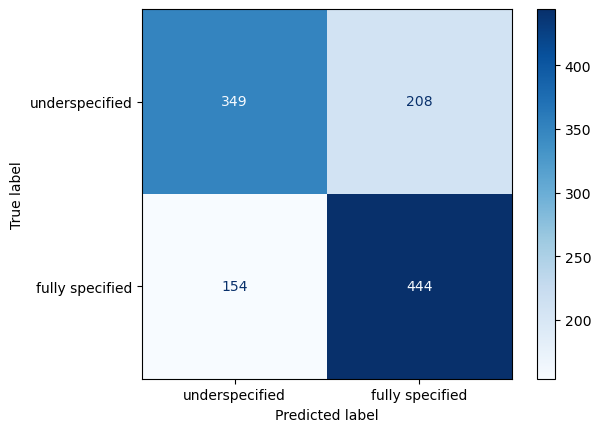

In [9]:
retrieve_results(experiment_result, 'test_2')

                 precision    recall  f1-score   support

fully specified       0.74      0.72      0.73       431
 underspecified       0.72      0.75      0.74       424

       accuracy                           0.73       855
      macro avg       0.73      0.73      0.73       855
   weighted avg       0.73      0.73      0.73       855



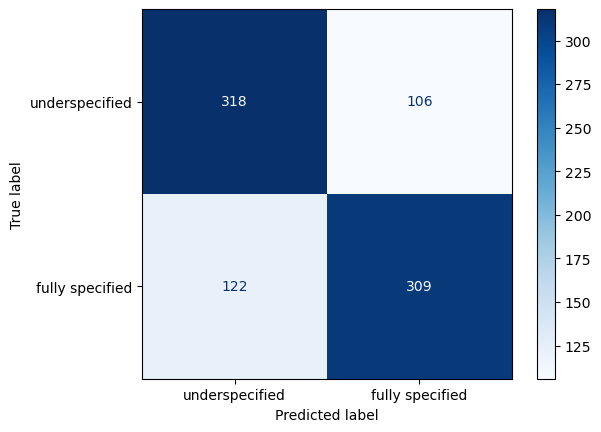

In [10]:
obtain_results_without('test_2.csv', 'AmbigQA')

In [11]:
history_data = model.history
import json

def convert_obj(obj):
    """将任意 Python/DSPy 对象转换为 JSON 可序列化结构，并尽量保留信息。"""
    if isinstance(obj, dict):
        return {k: convert_obj(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_obj(v) for v in obj]
    elif isinstance(obj, (str, int, float, bool)) or obj is None:
        return obj
    elif hasattr(obj, "text"):  # DSPy 的 response 类
        return {
            "_type": type(obj).__name__,
            "text": obj.text,
            "details": convert_obj(vars(obj))
        }
    elif hasattr(obj, "__dict__"):  # 一般自定义类
        return {
            "_type": type(obj).__name__,
            "attributes": convert_obj(vars(obj))
        }
    elif hasattr(obj, "__name__"):  # metaclass
        return {
            "_type": "metaclass",
            "name": obj.__name__
        }
    else:
        return {
            "_type": str(type(obj)),
            "repr": str(obj)
        }

# 处理 history
structured_history = [convert_obj(entry) for entry in model.history]

# 保存
with open("dspy_history_test_2.json", "w", encoding="utf-8") as f:
    json.dump(structured_history, f, ensure_ascii=False, indent=2)

In [13]:
test_1 = pd.read_csv('test_1.csv')
test_2 = pd.read_csv('test_2.csv')
find_model_pred_differences(test_1, test_2)

,request,gold_judgment_df1,model_pred_df1,model_pred_df2


# One more round of verification

In [6]:
model = dspy.LM("openai/Qwen/Qwen3-4B",
         api_base="http://localhost:7501/v1",
         api_key="whatever", model_type='chat',
         cache=False,
         temperature=0.0,
         max_tokens=5000)

In [7]:
loaded_dspy_program = dspy.load("./dspy_program/")

In [8]:
experiment_result = run_experiment(df_test_1155, model, loaded_dspy_program, 'test_1b_think_contents', theory=True)

Processing: 100%|██████████| 1155/1155 [2:08:27<00:00,  6.67s/it] 

The current length of history is 1346.
The number of thinking pieces is 1346.


No error is detected, proceed to evaluations.
                 precision    recall  f1-score   support

fully specified       0.68      0.74      0.71       598
 underspecified       0.69      0.63      0.66       557

       accuracy                           0.69      1155
      macro avg       0.69      0.68      0.68      1155
   weighted avg       0.69      0.69      0.68      1155



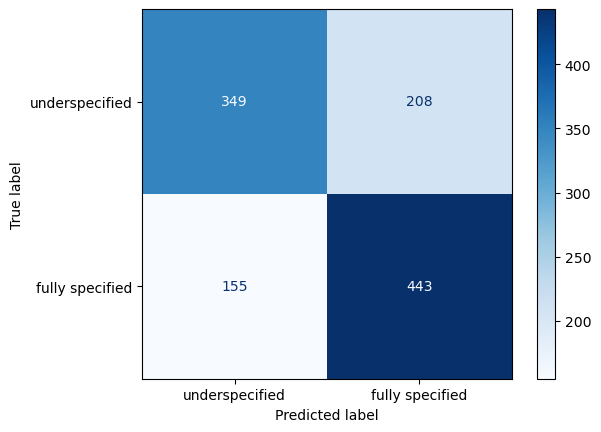

In [9]:
retrieve_results(experiment_result, 'test_1b')

                 precision    recall  f1-score   support

fully specified       0.74      0.71      0.73       431
 underspecified       0.72      0.75      0.74       424

       accuracy                           0.73       855
      macro avg       0.73      0.73      0.73       855
   weighted avg       0.73      0.73      0.73       855



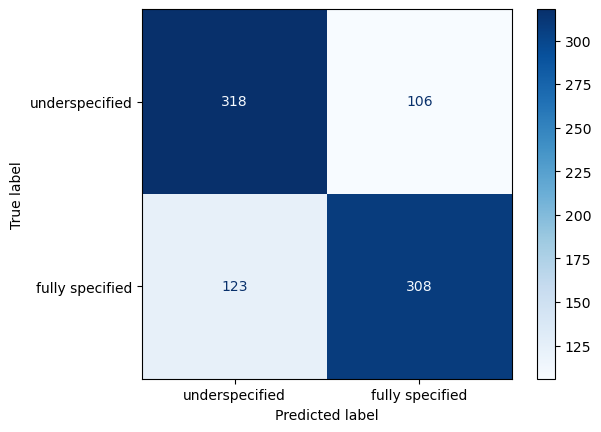

In [10]:
obtain_results_without('test_1b.csv', 'AmbigQA')

In [11]:
history_data = model.history
import json

def convert_obj(obj):
    """将任意 Python/DSPy 对象转换为 JSON 可序列化结构，并尽量保留信息。"""
    if isinstance(obj, dict):
        return {k: convert_obj(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_obj(v) for v in obj]
    elif isinstance(obj, (str, int, float, bool)) or obj is None:
        return obj
    elif hasattr(obj, "text"):  # DSPy 的 response 类
        return {
            "_type": type(obj).__name__,
            "text": obj.text,
            "details": convert_obj(vars(obj))
        }
    elif hasattr(obj, "__dict__"):  # 一般自定义类
        return {
            "_type": type(obj).__name__,
            "attributes": convert_obj(vars(obj))
        }
    elif hasattr(obj, "__name__"):  # metaclass
        return {
            "_type": "metaclass",
            "name": obj.__name__
        }
    else:
        return {
            "_type": str(type(obj)),
            "repr": str(obj)
        }

# 处理 history
structured_history = [convert_obj(entry) for entry in model.history]

# 保存
with open("dspy_history_test_1b.json", "w", encoding="utf-8") as f:
    json.dump(structured_history, f, ensure_ascii=False, indent=2)

In [12]:
test_1 = pd.read_csv('test_1.csv')
test_1b = pd.read_csv('test_1b.csv')
find_model_pred_differences(test_1, test_1b)

,request,gold_judgment_df1,model_pred_df1,model_pred_df2
359,Identify the top 5 performing stocks in the te...,fully specified,fully specified,underspecified


In [13]:
test_2 = pd.read_csv('test_2.csv')
test_1b = pd.read_csv('test_1b.csv')
find_model_pred_differences(test_2, test_1b)

,request,gold_judgment_df1,model_pred_df1,model_pred_df2
359,Identify the top 5 performing stocks in the te...,fully specified,fully specified,underspecified


# Yet another round

In [6]:
model = dspy.LM("openai/Qwen/Qwen3-4B",
         api_base="http://localhost:7501/v1",
         api_key="whatever", model_type='chat',
         cache=False,
         temperature=0.0,
         max_tokens=5000)

In [7]:
loaded_dspy_program = dspy.load("./dspy_program/")

In [8]:
experiment_result = run_experiment(df_test_1155, model, loaded_dspy_program, 'test_1c_think_contents', theory=True)

Processing: 100%|██████████| 1155/1155 [2:07:55<00:00,  6.65s/it] 

The current length of history is 1346.
The number of thinking pieces is 1346.


No error is detected, proceed to evaluations.
                 precision    recall  f1-score   support

fully specified       0.68      0.74      0.71       598
 underspecified       0.69      0.63      0.66       557

       accuracy                           0.69      1155
      macro avg       0.69      0.68      0.68      1155
   weighted avg       0.69      0.69      0.69      1155



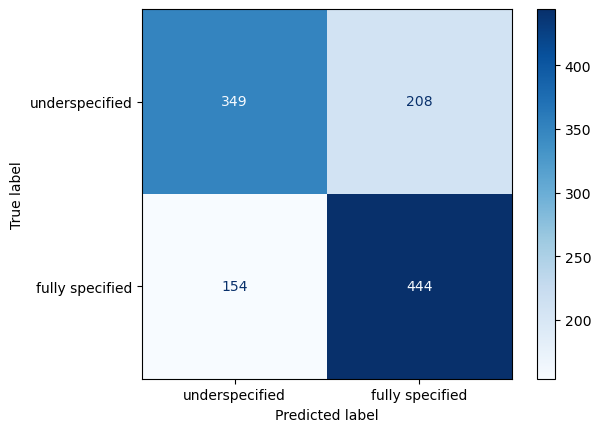

In [9]:
retrieve_results(experiment_result, 'test_1c')

                 precision    recall  f1-score   support

fully specified       0.74      0.72      0.73       431
 underspecified       0.72      0.75      0.74       424

       accuracy                           0.73       855
      macro avg       0.73      0.73      0.73       855
   weighted avg       0.73      0.73      0.73       855



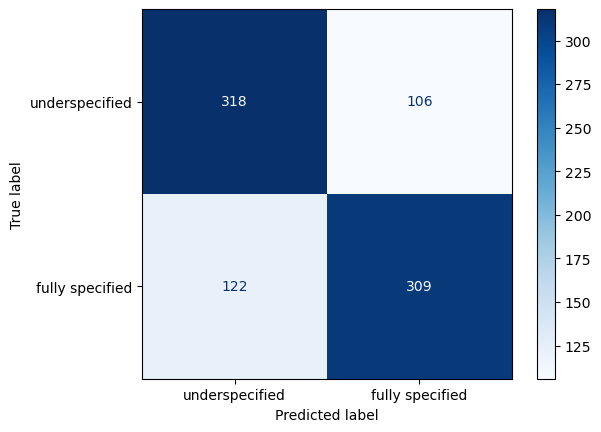

In [10]:
obtain_results_without('test_1c.csv', 'AmbigQA')

In [ ]:
history_data = model.history
import json

def convert_obj(obj):
    """将任意 Python/DSPy 对象转换为 JSON 可序列化结构，并尽量保留信息。"""
    if isinstance(obj, dict):
        return {k: convert_obj(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_obj(v) for v in obj]
    elif isinstance(obj, (str, int, float, bool)) or obj is None:
        return obj
    elif hasattr(obj, "text"):  # DSPy 的 response 类
        return {
            "_type": type(obj).__name__,
            "text": obj.text,
            "details": convert_obj(vars(obj))
        }
    elif hasattr(obj, "__dict__"):  # 一般自定义类
        return {
            "_type": type(obj).__name__,
            "attributes": convert_obj(vars(obj))
        }
    elif hasattr(obj, "__name__"):  # metaclass
        return {
            "_type": "metaclass",
            "name": obj.__name__
        }
    else:
        return {
            "_type": str(type(obj)),
            "repr": str(obj)
        }

# 处理 history
structured_history = [convert_obj(entry) for entry in model.history]

# 保存
with open("dspy_history_test_1c.json", "w", encoding="utf-8") as f:
    json.dump(structured_history, f, ensure_ascii=False, indent=2)

In [11]:
test_1 = pd.read_csv('test_1.csv')
test_1c = pd.read_csv('test_1c.csv')
find_model_pred_differences(test_1, test_1c)

,request,gold_judgment_df1,model_pred_df1,model_pred_df2


In [12]:
test_2 = pd.read_csv('test_2.csv')
test_1c = pd.read_csv('test_1c.csv')
find_model_pred_differences(test_2, test_1c)

,request,gold_judgment_df1,model_pred_df1,model_pred_df2


In [13]:
test_1b = pd.read_csv('test_1b.csv')
test_1c = pd.read_csv('test_1c.csv')
find_model_pred_differences(test_1b, test_1c)

,request,gold_judgment_df1,model_pred_df1,model_pred_df2
359,Identify the top 5 performing stocks in the te...,fully specified,underspecified,fully specified


# One more round

In [7]:
model = dspy.LM("openai/Qwen/Qwen3-4B",
         api_base="http://localhost:7501/v1",
         api_key="whatever", model_type='chat',
         cache=False,
         temperature=0.0,
         max_tokens=5000)

In [8]:
loaded_dspy_program = dspy.load("./dspy_program/")

In [9]:
experiment_result = run_experiment(df_test_1155, model, loaded_dspy_program, 'test_1d_think_contents', theory=True)

Processing: 100%|██████████| 1155/1155 [2:08:31<00:00,  6.68s/it] 

The current length of history is 1346.
The number of thinking pieces is 1346.


No error is detected, proceed to evaluations.
                 precision    recall  f1-score   support

fully specified       0.68      0.74      0.71       598
 underspecified       0.69      0.63      0.66       557

       accuracy                           0.69      1155
      macro avg       0.69      0.68      0.68      1155
   weighted avg       0.69      0.69      0.69      1155



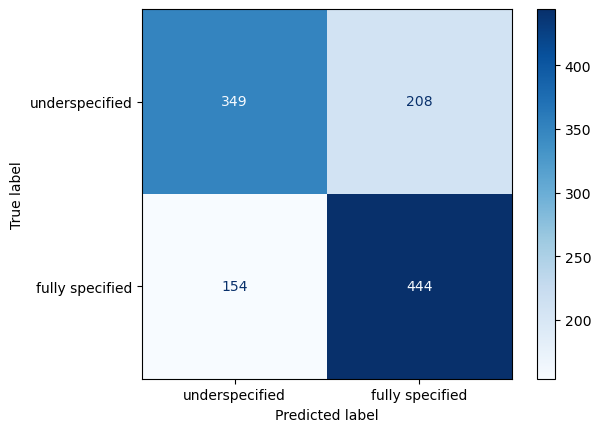

In [10]:
retrieve_results(experiment_result, 'test_1d')

                 precision    recall  f1-score   support

fully specified       0.74      0.72      0.73       431
 underspecified       0.72      0.75      0.74       424

       accuracy                           0.73       855
      macro avg       0.73      0.73      0.73       855
   weighted avg       0.73      0.73      0.73       855



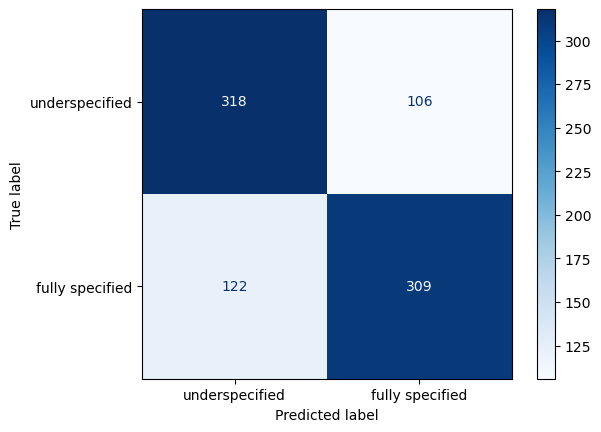

In [11]:
obtain_results_without('test_1d.csv', 'AmbigQA')

In [12]:
test_1 = pd.read_csv('test_1.csv')
test_1d = pd.read_csv('test_1d.csv')
find_model_pred_differences(test_1, test_1d)

,request,gold_judgment_df1,model_pred_df1,model_pred_df2


In [13]:
test_2 = pd.read_csv('test_2.csv')
test_1d = pd.read_csv('test_1d.csv')
find_model_pred_differences(test_2, test_1d)

,request,gold_judgment_df1,model_pred_df1,model_pred_df2


In [14]:
test_1b = pd.read_csv('test_1b.csv')
test_1d = pd.read_csv('test_1d.csv')
find_model_pred_differences(test_1b, test_1d)

,request,gold_judgment_df1,model_pred_df1,model_pred_df2
359,Identify the top 5 performing stocks in the te...,fully specified,underspecified,fully specified


In [15]:
test_1c = pd.read_csv('test_1c.csv')
test_1d = pd.read_csv('test_1d.csv')
find_model_pred_differences(test_1c, test_1d)

,request,gold_judgment_df1,model_pred_df1,model_pred_df2
